# Saving Monthly Surface and Bottom Temperatures

For access convenience elsewhere, save the monthly-averaged surface and bottom temperature data.

Surface and bottom layers have been isolated in `LOBECOL_Surfbot_Temp_Processing.ipynb`

In [1]:

####  Libraries  ####
import xarray as xr
import os
import numpy as np
import re
import dask

# Paths to resources
box_path = "/Users/adamkemberling/Library/CloudStorage/Box-Box/"
lobecol_path = f"{box_path}Mills Lab/Projects/Lobster ECOL/Spatial_Defs/"
glorys_path = f"{box_path}RES_Data/GLORYs/NE_Shelf_TempSal/"
glorys_path = "../GLORYS_surfbot_temps/"

# # Get all files
# fpaths_glorys = os.listdir(glorys_path)

# Pattern matching for .nc only
pattern = r".*\.nc$"  # Match all files ending with ".nc"

# list the .nc files
fpaths_glorys = []
for filename in os.listdir(glorys_path):
    if re.search(pattern, filename):
        fpaths_glorys.append(f"{glorys_path}{filename}")

# Check files are there
fpaths_glorys[0:6]

['../GLORYS_surfbot_temps/CMEMS_Northeast_TempSal_SurfaceBottomTemps_2011.nc',
 '../GLORYS_surfbot_temps/CMEMS_Northeast_TempSal_SurfaceBottomTemps_2001.nc',
 '../GLORYS_surfbot_temps/CMEMS_Northeast_TempSal_SurfaceBottomTemps_2015.nc',
 '../GLORYS_surfbot_temps/CMEMS_Northeast_TempSal_SurfaceBottomTemps_2021.nc',
 '../GLORYS_surfbot_temps/CMEMS_Northeast_TempSal_SurfaceBottomTemps_1994.nc',
 '../GLORYS_surfbot_temps/CMEMS_Northeast_TempSal_SurfaceBottomTemps_2005.nc']

In [2]:
# Load all of the Glorys year as one file
# # Lazy-load the data itself using xr.open_mfdataset
glorys_all = xr.open_mfdataset(fpaths_glorys, combine = "by_coords", parallel = True)
glorys_all

<xarray.Dataset> Size: 7GB
Dimensions:       (time: 11618, latitude: 132, longitude: 226)
Coordinates:
  * time          (time) datetime64[ns] 93kB 1993-01-01 ... 2024-10-22
  * latitude      (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude     (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
Data variables:
    bottom_temp   (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    bottom_depth  (time, latitude, longitude) float32 1GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    surface_temp  (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>

# Summarise to Monthly Means

Take the surface and bottom layers and estimate monthly averages. Do a 30-year climatology and get differences from that as well.

/Users/adamkemberling/micromamba/envs/copernicusmarine/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


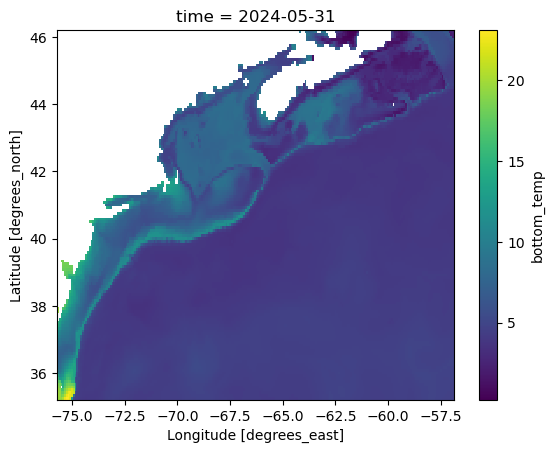

In [3]:
# Resample to monthly averages
glorys_monthly = glorys_all.resample(time='1M').mean()

# Plot one month
glorys_monthly.isel(time = -6).bottom_temp.plot()

### Make Monthly Climatology

Take 30-year period 1993-2022

In [4]:
# Get monthly climatology
glorys_clim = glorys_all.sel(time=slice("1993-01-01", "2022-12-31")).groupby("time.month").mean("time")
glorys_clim

<xarray.Dataset> Size: 7MB
Dimensions:       (month: 12, latitude: 132, longitude: 226)
Coordinates:
  * latitude      (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude     (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
  * month         (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    bottom_temp   (month, latitude, longitude) float64 3MB dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    bottom_depth  (month, latitude, longitude) float32 1MB dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    surface_temp  (month, latitude, longitude) float64 3MB dask.array<chunksize=(1, 132, 226), meta=np.ndarray>

In [5]:
# Step 3: Use .groupby() on monthly_avg_within_years and broadcast monthly_avg_across_years
difference = glorys_monthly.groupby("time.month") - glorys_clim
difference = difference[['surface_temp', 'bottom_temp']]
difference = difference.rename({'surface_temp': 'surface_temp_anom', 'bottom_temp': 'bottom_temp_anom'})
difference

# # Step 2: Rejoin `difference_renamed` with `monthly_avg_within_years`
# glorys_monthly_new = glorys_monthly.merge(difference)
# glorys_monthly_new

/Users/adamkemberling/micromamba/envs/copernicusmarine/lib/python3.12/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 32 times more chunks
  return self.array[key]


<xarray.Dataset> Size: 182MB
Dimensions:            (time: 382, latitude: 132, longitude: 226)
Coordinates:
  * latitude           (latitude) float32 528B 35.25 35.33 35.42 ... 46.08 46.17
  * longitude          (longitude) float32 904B -75.67 -75.58 ... -57.0 -56.92
  * time               (time) datetime64[ns] 3kB 1993-01-31 ... 2024-10-31
    month              (time) int64 3kB 1 2 3 4 5 6 7 8 9 ... 2 3 4 5 6 7 8 9 10
Data variables:
    surface_temp_anom  (time, latitude, longitude) float64 91MB dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    bottom_temp_anom   (time, latitude, longitude) float64 91MB dask.array<chunksize=(1, 132, 226), meta=np.ndarray>

In [6]:
# OPTIONAL: Prep climatology to ship with the data

# Step 4: Align `monthly_avg_across_years` with `monthly_avg_within_years` by mapping over each month
clim_aligned = glorys_monthly.groupby("time.month").map(
    lambda x: glorys_clim.sel(month = x["time.month"]))
clim_aligned = clim_aligned.rename({"bottom_temp" : "btemp_clim", "surface_temp" : "stemp_clim"})[["stemp_clim", "btemp_clim"]]
clim_aligned

/Users/adamkemberling/micromamba/envs/copernicusmarine/lib/python3.12/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 32 times more chunks
  return self.array[key]


<xarray.Dataset> Size: 182MB
Dimensions:     (time: 382, latitude: 132, longitude: 226)
Coordinates:
  * latitude    (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude   (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
    month       (time) int64 3kB 1 2 3 4 5 6 7 8 9 10 ... 1 2 3 4 5 6 7 8 9 10
  * time        (time) datetime64[ns] 3kB 1993-01-31 1993-02-28 ... 2024-10-31
Data variables:
    stemp_clim  (time, latitude, longitude) float64 91MB dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    btemp_clim  (time, latitude, longitude) float64 91MB dask.array<chunksize=(1, 132, 226), meta=np.ndarray>

In [7]:
# Step 5: Merge everything into a single dataset
glorys_combined_ds = glorys_monthly.merge(difference)#.merge(clim_aligned)
glorys_combined_ds = glorys_combined_ds.drop("month")
glorys_combined_ds

/var/folders/1j/txwqbs3j2n5f_c2pgm0yn2rc0000gn/T/ipykernel_7702/583024219.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  glorys_combined_ds = glorys_combined_ds.drop("month")


<xarray.Dataset> Size: 410MB
Dimensions:            (time: 382, latitude: 132, longitude: 226)
Coordinates:
  * latitude           (latitude) float32 528B 35.25 35.33 35.42 ... 46.08 46.17
  * longitude          (longitude) float32 904B -75.67 -75.58 ... -57.0 -56.92
  * time               (time) datetime64[ns] 3kB 1993-01-31 ... 2024-10-31
Data variables:
    bottom_temp        (time, latitude, longitude) float64 91MB dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    bottom_depth       (time, latitude, longitude) float32 46MB dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    surface_temp       (time, latitude, longitude) float64 91MB dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    surface_temp_anom  (time, latitude, longitude) float64 91MB dask.array<chunksize=(1, 132, 226), meta=np.ndarray>
    bottom_temp_anom   (time, latitude, longitude) float64 91MB dask.array<chunksize=(1, 132, 226), meta=np.ndarray>

In [8]:
# Export that to box
box_path = "/Users/adamkemberling/Library/CloudStorage/Box-Box/"
box_glorys = f"{box_path}RES_Data/GLORYs/NE_Shelf_TempSal_Monthly/"
glorys_combined_ds.to_netcdf(f"{box_glorys}Northwest_Atlantic_Surface_Bottom_93to2022_anoms.nc")
glorys_clim.to_netcdf(f"{box_glorys}Northwest_Atlantic_Surface_Bottom_93to2022_clim.nc")